In [1]:
from PIL import Image
import glob
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
# 가위 이미지 불러와서 28X28 사이즈 변경
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
#image_dir_path = os.getenv("HOME") + "/Documents/아이펠/[EX_01]/train_data/scissor"
image_dir_path = "train_data/scissor"
print(image_dir_path)
resize_images(image_dir_path)


print("가위 이미지 resize 완료!")

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path1 = "train_data/rock"
resize_images(image_dir_path1)

print("바위 이미지 resize 완료!")

# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
#image_dir_path2 = os.getenv("HOME") + "~/train_data/paper"
image_dir_path2 = 'train_data/paper'
resize_images(image_dir_path2)

print("보 이미지 resize 완료!")

train_data/scissor
1300  images to be resized.
1300  images resized.
가위 이미지 resize 완료!
1300  images to be resized.
1300  images resized.
바위 이미지 resize 완료!
1300  images to be resized.
1300  images resized.
보 이미지 resize 완료!


# 데이터 가져오는 load_data() 함수 만들기

In [3]:
def load_data(img_path, number_of_data=3900):
    img_size=28
    color=3
    # 이미지 데이터와 라벨 데이터 담을 행렬 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    idx=0
    
    # glob() 함수는 인자로 받은 패턴과 이름 일치하는 모든 파일과 디렉터리의 리스트 반환
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32) # 예를 들어 0.jpg을 가지고 온다면
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        # imgs[0,28(img_size_w),28(img_size_h),color]=img 
        
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

#image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
image_dir_path = "train_data/"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 3900 입니다.
x_train shape: (3900, 28, 28, 3)
y_train shape: (3900,)


라벨:  0


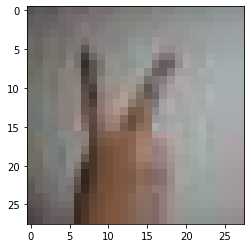

In [4]:
from matplotlib import pyplot as plt
plt.imshow(x_train[300])
print('라벨: ', y_train[300])

In [5]:
print(len(x_train))
print(len(y_train))

3900
3900


In [6]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_norm, y_train, epochs=n_train_epoch)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 32)                2

# 테스트셋 만들기

In [7]:
# 이미지 사이즈 28x28로 변경
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
#image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
image_dir_path = "test_data/scissor"
resize_images(image_dir_path)
#image_dir_path1 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
image_dir_path1 = "test_data/rock"
resize_images(image_dir_path1)
#image_dir_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
image_dir_path2 = "test_data/paper"
resize_images(image_dir_path2)

print("모든 이미지 resize 완료!")

300  images to be resized.
300  images resized.
300  images to be resized.
300  images resized.
300  images to be resized.
300  images resized.
모든 이미지 resize 완료!


In [8]:
def load_test(img_path, number_of_data=900):
    img_size=28
    color=3
    # 이미지 데이터와 라벨 데이터 담을 행렬 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "test_data"
(x_test, y_test)=load_test(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_test)의 이미지 개수는 900 입니다.
x_test shape: (900, 28, 28, 3)
y_test shape: (900,)


# 평가하기

In [9]:
# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

29/29 - 0s - loss: 1.8284 - accuracy: 0.6433 - 258ms/epoch - 9ms/step
test_loss: 1.8283898830413818 
test_accuracy: 0.6433333158493042
